In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
import json

import rff
import koopman
import Duffing

In [2]:
# Load parameter file:
json_file = open("Duff_parameters.json", 'r')
param = json.load(json_file)
# System parameters:
alpha = param["alpha"]
beta = param["beta"]
# Define system class:]
Duff = Duffing.Duffing(alpha, beta, 0.0)

In [3]:
# Kernel bandwidth:
sigma = param["sigma_show"]
# Feature numbers:
p = param["p_show"]
# Regularization tolerance:
tol = param["tol_show"]
# Box size for initial conditions:
L = param["L"]
# Box size for prediction:
Lpre = param["Lpre"]
# Number of training points:
n_learn = param["n_learn"]

In [4]:
# Simulation time step:
dt = param["dt"]
# Lag time for Koopman learning:
tau = param["tau"]
# Number of time steps for model validation:
nsteps_train = param["nsteps"]
# Frequency of project-and-lift step:
dlift = param["dlift"]
# Number of simulation steps (in multiples of the lag time):
nsteps = param["nsteps_long"]
# Vector of simulation times:
tsim = np.linspace(0, dt*nsteps*tau, nsteps+1)
# Number of simulations:
nsim = param["nsim_long"]

In [5]:
""" Generate training data: """
# Draw initial conditions:
X = 2 * L * np.random.rand(2, n_learn) - L
print("Generated initial conditions of shape: ", X.shape)
# Generate trajectories:
Y = Duff.simulate(X, dt, tau, 1.0)[0][:, -1, :]
print(Y.shape)

Generated initial conditions of shape:  (2, 10000)
(2, 10000)


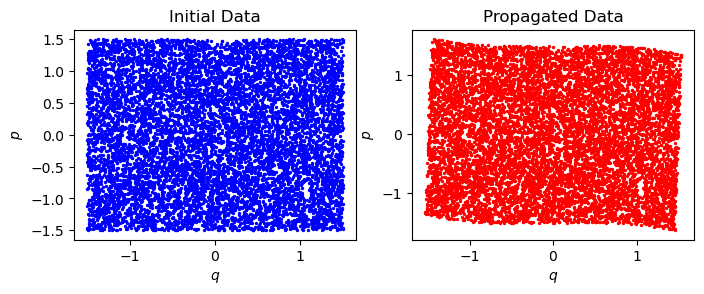

In [6]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.scatter(X[0, :], X[1, :], c="b", s=2)
plt.title("Initial Data")
plt.xlabel(r"$q$")
plt.ylabel(r"$p$")

plt.subplot(2, 2, 2)
plt.scatter(Y[0, :], Y[1, :], c="r", s=2)
plt.title("Propagated Data")
plt.xlabel(r"$q$")
plt.ylabel(r"$p$")

plt.savefig("Figures/Duffing_TrainingData.pdf", bbox_inches="tight")

In [7]:
""" Model Training """
Omega = rff.sample_rff_gaussian(2, p, sigma)
Phi = rff.RFF_Finite(Omega)
""" Fit the constant function : """
print("Fitting the constant...")
M = Phi(X)
vx = -scl.pinv(M.conj().T) @ X[0, :]
vy = -scl.pinv(M.conj().T) @ X[1, :]
V = np.vstack((vx, vy))
""" Learn Koopman model: """
print("Fitting Koopman models...")
K = koopman.koopman_matrix(X.astype(complex),Y.astype(complex), Phi, tol)
print(K.shape)

Fitting the constant...
Fitting Koopman models...
(500, 500)


In [8]:
""" Model Prediction: """
# Generate initial data for prediction:
x0 = 2 * Lpre * np.random.rand(2, nsim) - Lpre
# Generate long trajectories:
print("Generating long simulations...")
y = Duff.simulate(x0, dt, tau*nsteps, 1.0)[0][:, ::tau, :]
print(y.shape)
# Predict state with Koopman:
print("Predicting state with Koopman model...")
ztraj = koopman.prediction_koopman(K, x0.astype(complex), Phi, V,
                                nsteps, dt*tau, dlift=dlift)
ztraj = np.tensordot(V, ztraj, axes=([1], [0]))
print(ztraj.shape)

Generating long simulations...
(2, 501, 10)
Predicting state with Koopman model...
(2, 501, 10)


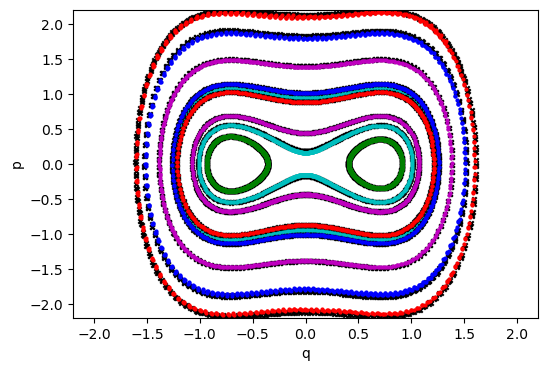

In [10]:
""" Show results: """
colors = ["c", "b", "m", "r", "g"]
plt.figure(figsize=(6, 4))
ax = plt.gca()
for ii in range(nsim):
    plt.scatter(y[0, :, ii], y[1, :, ii], c="k", marker="x", s=10)
    plt.scatter(np.real(ztraj)[0, :, ii], np.real(ztraj)[1, :, ii],
                 c="%s"%(colors[ii%5]), marker="o", s=4)

plt.xlim([-2.2, 2.2])
plt.ylim([-2.2, 2.2])
plt.xlabel("q")
plt.ylabel("p")

plt.savefig("Figures/Duffing_KOP_Prediction.pdf", bbox_inches="tight")